In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from math import sqrt
import yfinance as yf
from datetime import datetime
from sklearn.pipeline import Pipeline
plt.style.use('ggplot')

### Parâmetros

In [57]:
p = '10y' #Período de coleta dos dados (10y = 10 anos)
i = '1d' #Invtervalo (1d = diário)
ticker = 'BTC-USD' #Código da ação que deseja atuar (^GSPC = Sp500)
qt_teste = 300 #Tamanho da amostragem de teste (recomendado min=300)

### Base de dados

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

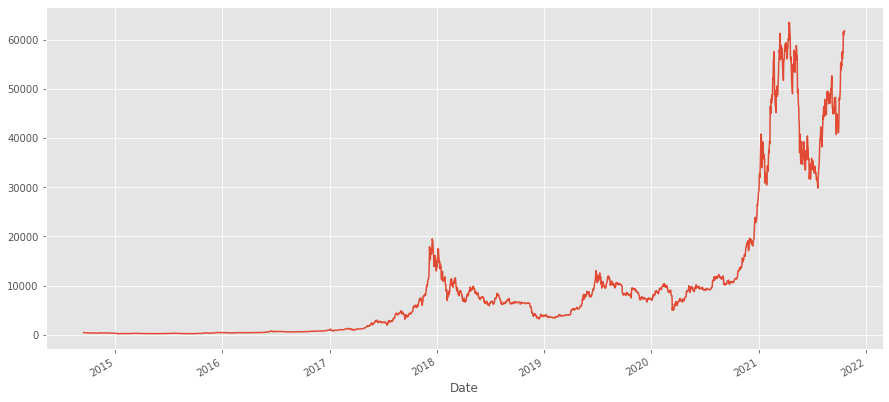

In [58]:
# Loading the dataset
df = yf.download(tickers=ticker, period = p, interval = i)
df.drop(df[df['Volume']==0].index, inplace = True)
df['Close'].plot(figsize=(15,7))

In [59]:
#Variável do fechamento do dia seguinte
df['Close+1'] = df['Close'].shift(-1)
df['Close+1'] = df['Close+1'].fillna(df['Close+1'].rolling(10,min_periods=1).median())
df

,Open,High,Low,Close,Adj Close,Volume,Close+1
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,424.440002
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,394.795990
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,408.903992
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,398.821014
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,402.152008
...,...,...,...,...,...,...,...
2021-10-14,57372.832031,58478.734375,56957.074219,57321.523438,57321.523438,36615791366,61593.949219
2021-10-15,57345.902344,62757.128906,56868.144531,61593.949219,61593.949219,51780081801,60892.179688
2021-10-16,61609.527344,62274.476562,60206.121094,60892.179688,60892.179688,34250964237,61553.617188


In [60]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.figure(figsize=(15,7))
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('SP500')
    plt.xlabel('Dia')
    plt.ylabel('Fechamento')
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [61]:
def vwap(df):
    v = df['Volume'].values
    tp = (df['Low'] + df['Close'] + df['High']).div(3).values
    return df.assign(Vwap=(tp * v).cumsum() / v.cumsum())

In [62]:
df = vwap(df)

In [63]:
#Criando novos campos de medias móveis
df['mm5'] = df['Close+1'].rolling(5).mean()
df['mm21'] = df['Close+1'].rolling(21).mean()
df.dropna(inplace=True)
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Close+1      0
Vwap         0
mm5          0
mm21         0
dtype: int64

In [64]:
# Correlation matrix
df.corr()['Close+1']

Open         0.997498
High         0.998180
Low          0.997971
Close        0.998674
Adj Close    0.998674
Volume       0.768964
Close+1      1.000000
Vwap         0.858832
mm5          0.998465
mm21         0.990743
Name: Close+1, dtype: float64

### Model Building

In [65]:
# Extracting the series
features = ['Close+1', 'Open', 'Low', 'High', 'mm5', 'mm21', 'Vwap']
series = df[features]
print(series.shape)
print(series.tail())

(2565, 7)
                 Close+1          Open           Low          High  \
Date                                                                 
2021-10-14  61593.949219  57372.832031  56957.074219  58478.734375   
2021-10-15  60892.179688  57345.902344  56868.144531  62757.128906   
2021-10-16  61553.617188  61609.527344  60206.121094  62274.476562   
2021-10-17  61790.750000  60887.652344  59164.468750  61645.523438   
2021-10-19  57484.789062  61925.964844  61767.015625  62235.054688   

                     mm5          mm21          Vwap  
Date                                                  
2021-10-14  57968.483594  50567.821987  24701.314660  
2021-10-15  58649.961719  51433.326079  24753.494350  
2021-10-16  59752.473437  52306.901228  24788.619179  
2021-10-17  60630.403906  53238.092634  24818.064042  
2021-10-19  60663.057031  54021.437686  24857.198097  


In [66]:
# Train Val Test Split
train =  series.iloc[:-qt_teste,]
test = series.iloc[-qt_teste:]

feats_train = ['Open', 'Low', 'High','mm5', 'mm21', 'Vwap']
target = 'Close+1'

print(train.shape,test.shape)

(2265, 7) (300, 7)


In [67]:
#Treinando modelo
pipeline = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', LinearRegression())])
X_train, y_train = train[feats_train], train[target]
pipeline.fit(X_train, y_train)

Pipeline(steps=[('normalize', MinMaxScaler()), ('model', LinearRegression())])

R2: 0.9648
MAE: 1366.8304
MSE: 3247595.3001
RMSE: 1802.1086


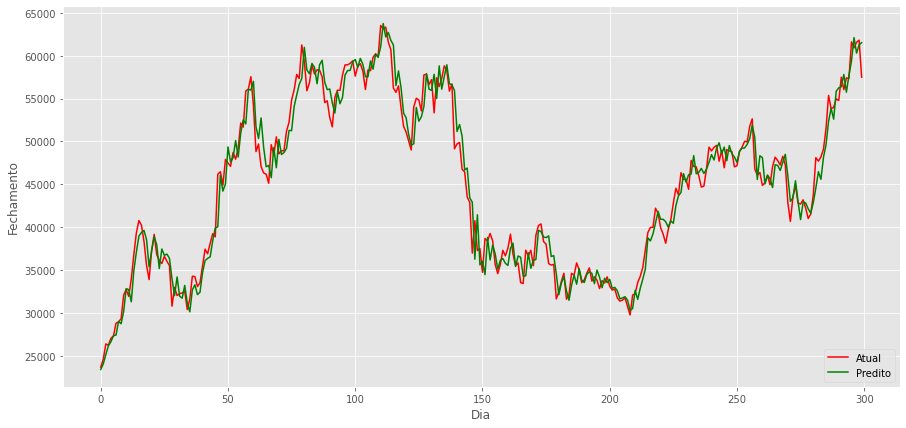

In [68]:
#Validando modelo
X_test, y_test = test[feats_train], test[target].reset_index(drop=True)
pred = pipeline.predict(X_test)
cd = r2_score(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test,pred))
mse = mean_squared_error(y_test,pred)
mae = mean_absolute_error(y_test,pred)
print('R2: '+str(round(cd,4)))
print('MAE: '+str(round(mae,4)))
print('MSE: '+str(round(mse,4)))
print('RMSE: '+str(round(rmse,4)))
plot_data(y_test,pred)

In [69]:
#Prevendo próximo fechamento
print(datetime.now().strftime("%d/%m/%Y, %H:%M:%S"))
last = 2
X_train, y_train = series[feats_train], series[target]
pipeline.fit(X_train, y_train)
pred = pipeline.predict(df[-last:][feats_train])
#print('Real: ',y_train[-(last)])
#print('Real-1: ',y_train[-(last+1)])
print('\nPróximo fechamento: ',pred[0])
tax = (1-(y_train[-(last+1)]/pred[0]))*100
print('Taxa(%): ',tax)

18/10/2021, 23:00:29
Real:  61790.75
Real-1:  61553.6171875

Próximo fechamento:  61382.21668174026
Taxa(%):  -0.279234793113492
